In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
from tensorflow.keras.layers import Embedding, Input, Dropout, Dense, Activation, Reshape, LayerNormalization, Concatenate
from tensorflow.keras.models import Model

In [3]:
input_sequence_length=10
output_sequence_length=100
d_model=512
src_vocab_size=10000
trg_vocab_size=20000
n_blocks_encoder=6
n_blocks_decoder=6
n_heads=8
layer1_units_ff=2048
layer2_units_ff=512
dropout_rate=0.1
input_shape_encoder=(input_sequence_length,)
input_shape_decoder=(output_sequence_length,)
intermediate_shape_encoder=(input_sequence_length,d_model)
intermediate_shape_decoder=(output_sequence_length,d_model)
mask_shape_encoder=(n_heads,input_sequence_length,input_sequence_length)
mask_shape_cross=(n_heads,output_sequence_length,input_sequence_length)
mask_shape_decoder=(n_heads,output_sequence_length,output_sequence_length)

In [4]:
def SequenceEmbedding(input_shape,d_model,vocab_size,dropout_rate,initializers=tf.keras.initializers.glorot_uniform(seed=1)):

    sequence_length = input_shape[0]
    # Create matrix of shape (seq_len,d_model)
    positionalEncoding = np.zeros((sequence_length,d_model))
    # Create vector of shape (seq_len,1)
    position = np.arange(0,sequence_length).reshape(-1,1)
    # Create denominator of shape (1,d_model)
    div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
    # Apply sin to even positions and cos to odd positions
    positionalEncoding[:,0::2] = np.sin(position*div_term)
    positionalEncoding[:,1::2] = np.cos(position*div_term)
    # Reshape to (1,seq_len,)
    positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

    # Model Architecture
    input = Input(shape=input_shape,name="EmbeddingLayer_Input")

    # Create Input Embedding Layer
    x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding")(input)
    x = x/np.sqrt(d_model)

    # Add Positional Embedding
    x = x + positionalEncoding[:,:x.shape[1],:]
    
    # Dropout
    x = Dropout(rate=dropout_rate,name="Input_Dropout")(x)

    model = Model(inputs=[input],outputs=[x],name="SequenceEmbedding")

    return model


In [5]:
model=SequenceEmbedding(input_shape_encoder,d_model,src_vocab_size,dropout_rate)
model.summary()

Model: "SequenceEmbedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer_Input (Input  [(None, 10)]             0         
 Layer)                                                          
                                                                 
 Input_Embedding (Embedding)  (None, 10, 512)          5120000   
                                                                 
 tf.math.truediv (TFOpLambda  (None, 10, 512)          0         
 )                                                               
                                                                 
 tf.__operators__.add (TFOpL  (None, 10, 512)          0         
 ambda)                                                          
                                                                 
 Input_Dropout (Dropout)     (None, 10, 512)           0         
                                                 

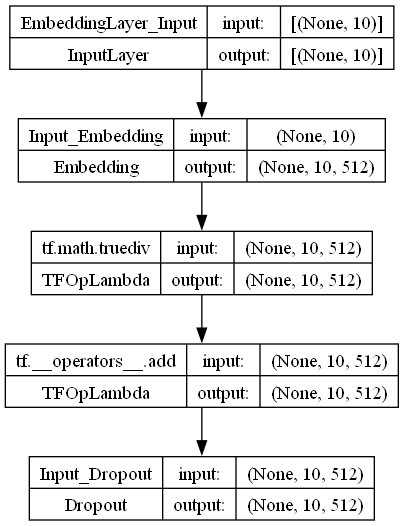

In [6]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [7]:
model=SequenceEmbedding(input_shape_decoder,d_model,trg_vocab_size,dropout_rate)
model.summary()

Model: "SequenceEmbedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer_Input (Input  [(None, 100)]            0         
 Layer)                                                          
                                                                 
 Input_Embedding (Embedding)  (None, 100, 512)         10240000  
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 100, 512)         0         
 da)                                                             
                                                                 
 tf.__operators__.add_1 (TFO  (None, 100, 512)         0         
 pLambda)                                                        
                                                                 
 Input_Dropout (Dropout)     (None, 100, 512)          0         
                                                 

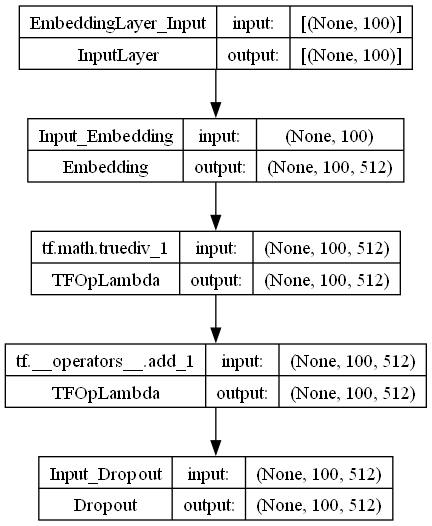

In [8]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [9]:
def MultiHeadAttention(input_shape_query,input_shape_key,input_shape_value,mask_shape,d_model,heads,dropout_rate,index=0):
    
    d_k = d_model // heads

    # Define mask
    mask = Input(shape=mask_shape,name="MHAInput_mask")
    # Define key, query and value
    query_input = Input(shape=input_shape_query,name="MultiHeadAttention_query_Input")
    key_input = Input(shape=input_shape_key,name="MultiHeadAttention_key_Input")
    value_input = Input(shape=input_shape_value,name="MultiHeadAttention_value_Input")

    query = Dense(d_model,name="Query_Creator",)(query_input)
    key = Dense(d_model,name="Key_Creator")(key_input)
    value = Dense(d_model,name="Value_Creator")(value_input)

    query = Reshape((query.shape[1],heads,d_k),name="Query_reshaper")(query)
    query = tf.transpose(query,perm=[0,2,1,3],name="Query_transposer")

    key = Reshape((key.shape[1],heads,d_k),name="Key_reshaper")(key)
    key = tf.transpose(key,perm=[0,2,1,3])
    key = tf.transpose(key,perm=[0,1,3,2])

    value = Reshape((value.shape[1],heads,d_k),name="Value_reshaper")(value)
    value = tf.transpose(value,perm=[0,2,1,3])

    attention_scores = (query @ key)/np.sqrt(d_k)

    if mask is not None:
        attention_scores = attention_scores*mask
    attention_scores = tf.nn.softmax(attention_scores,axis=-1)
    if dropout_rate is not None:
        attention_scores = Dropout(rate=dropout_rate,name="MultiHeadAttention_dropout")(attention_scores)
    
    x = attention_scores @ value
    x = tf.transpose(x,perm=[0,2,1,3])
    x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name="Output_reshaper")(x)

    x = Dense(d_model,name="Output_creator")(x)
    
    model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"MultiHeadAttention_{index}")

    return model


In [10]:
model=MultiHeadAttention(intermediate_shape_encoder,intermediate_shape_encoder,intermediate_shape_encoder,mask_shape_encoder,d_model,n_heads,dropout_rate)
model.summary()

Model: "MultiHeadAttention_0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MultiHeadAttention_key_Input (  [(None, 10, 512)]   0           []                               
 InputLayer)                                                                                      
                                                                                                  
 MultiHeadAttention_query_Input  [(None, 10, 512)]   0           []                               
  (InputLayer)                                                                                    
                                                                                                  
 Key_Creator (Dense)            (None, 10, 512)      262656      ['MultiHeadAttention_key_Input[0]
                                                                 [0]']         

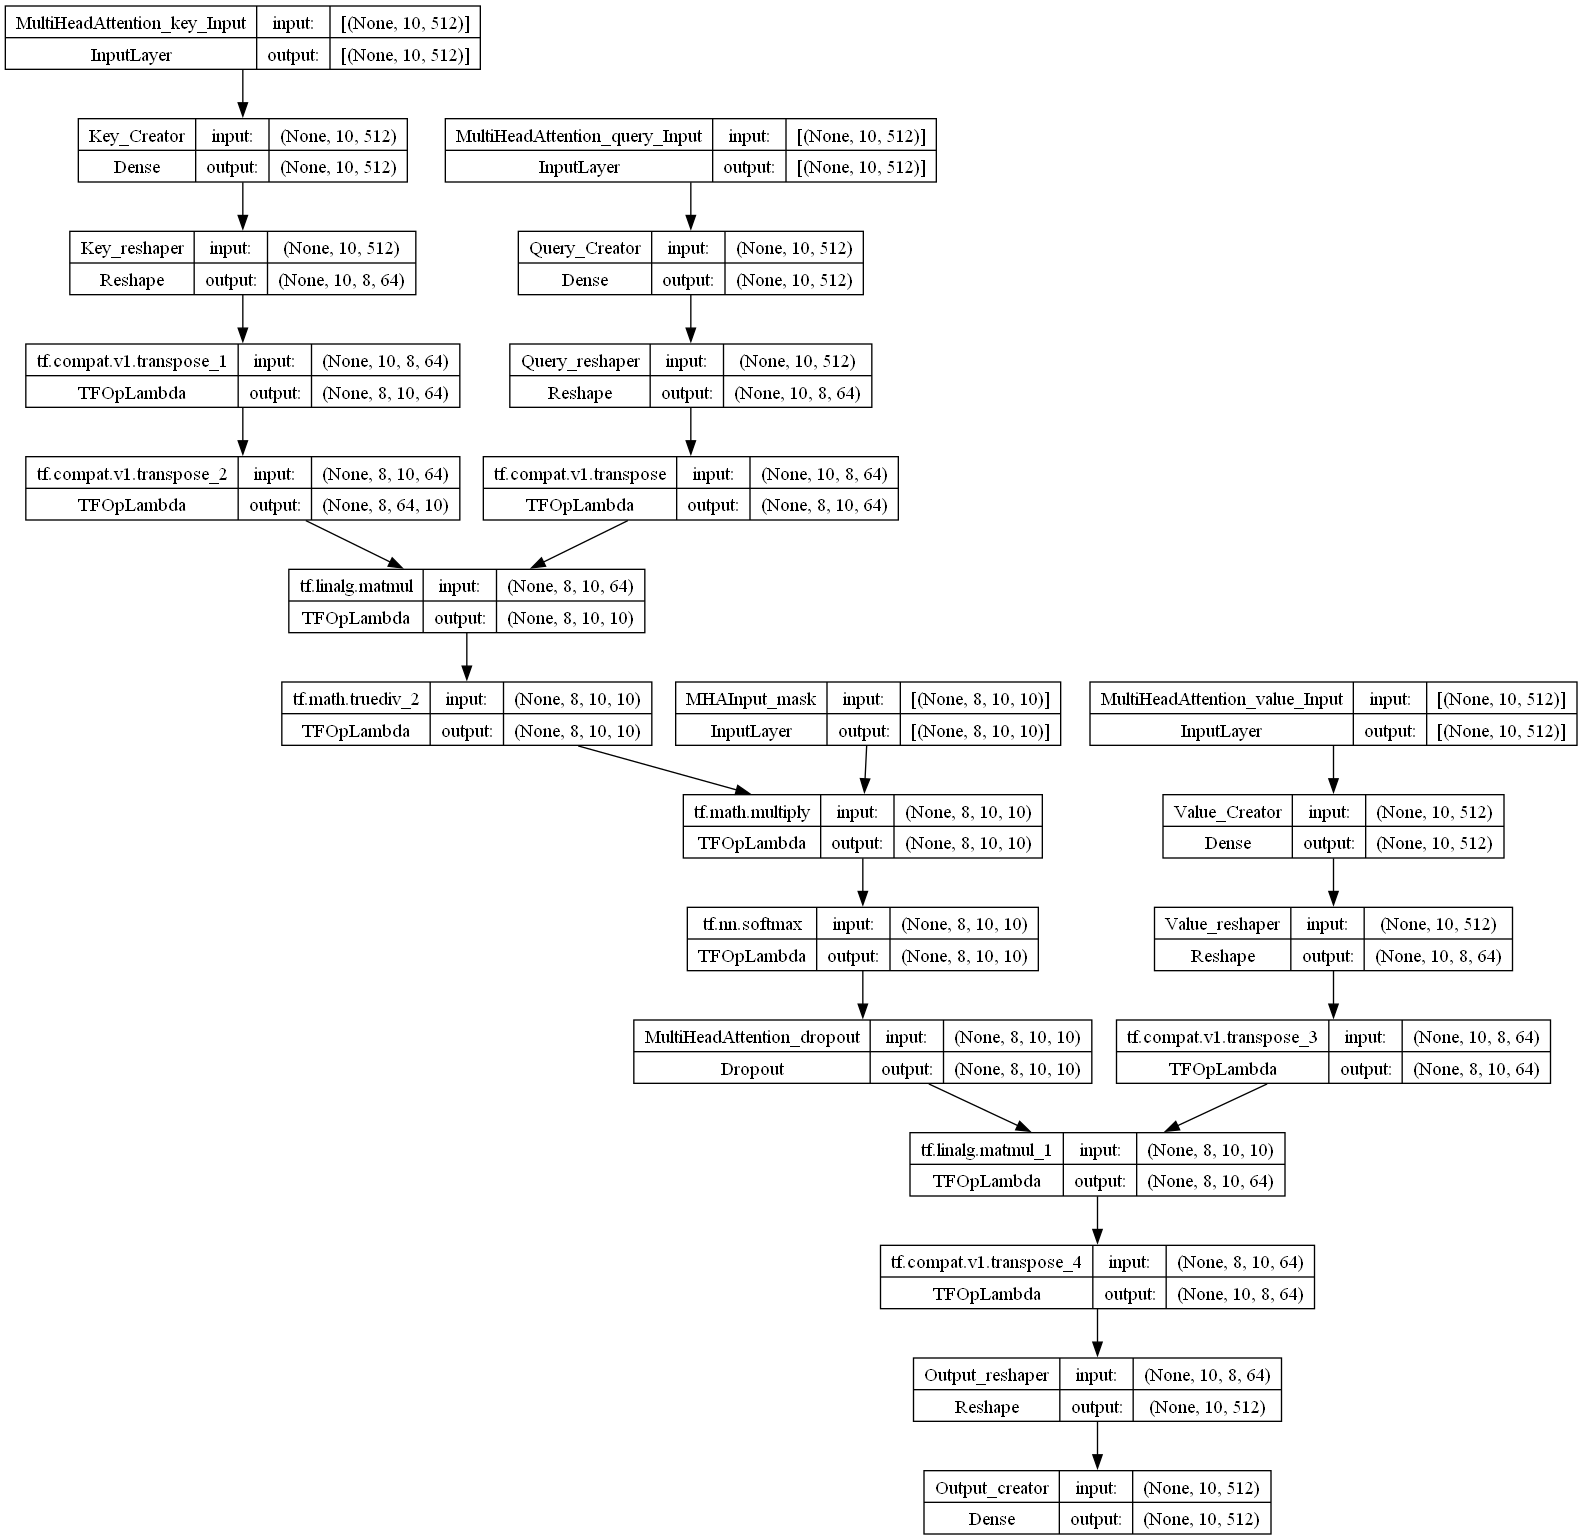

In [11]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [12]:
def FeedForward(input_shape,layer1_units,layer2_units,dropout_rate,index=0):

    # Pick up input
    input = Input(shape = input_shape,name="FeedForwardInput")
    # First Dense layer
    x = Dense(layer1_units,name="FeedForwardDense1")(input)
    # Relu activation
    x = Activation('relu',name="FeedForwardRelu")(x)
    # Dropouts
    x = Dropout(dropout_rate,name="FeedForwardDropout")(x)
    # Second Dense Layer
    x = Dense(layer2_units,name="FeedForwardDense2")(x)

    model = Model(inputs=[input],outputs=[x],name=f"FeedForward_{index}")

    return model

In [13]:
model=FeedForward(intermediate_shape_encoder,layer1_units_ff,layer2_units_ff,dropout_rate)
model.summary()

Model: "FeedForward_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeedForwardInput (InputLaye  [(None, 10, 512)]        0         
 r)                                                              
                                                                 
 FeedForwardDense1 (Dense)   (None, 10, 2048)          1050624   
                                                                 
 FeedForwardRelu (Activation  (None, 10, 2048)         0         
 )                                                               
                                                                 
 FeedForwardDropout (Dropout  (None, 10, 2048)         0         
 )                                                               
                                                                 
 FeedForwardDense2 (Dense)   (None, 10, 512)           1049088   
                                                     

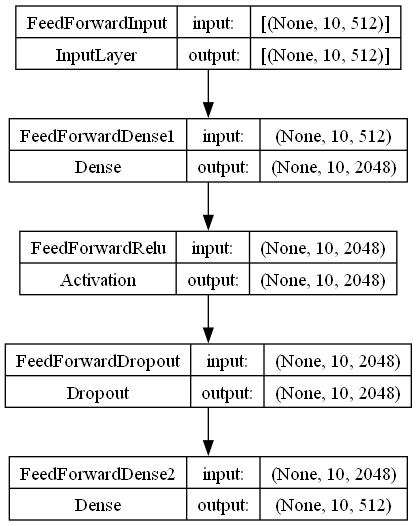

In [14]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [15]:
def ResidualConnectionMHA(input,sub_layer,dropout_rate,index=0):

    # Layer Normalization
    x = LayerNormalization(name=f"ResidualConnectionMHALayerNormalization_{index}")(input)
    # MHA Layer
    [x, a] = sub_layer(x)
    # Dropouts
    x = Dropout(rate=dropout_rate,name=f"ResidualConnectionMHADropout_{index}")(x)
    # Residual Connection
    x = input + x

    return x, a

In [16]:
def ResidualConnectionFF(input,sub_layer,dropout_rate,index=0):

    # Layer Normalization
    x = LayerNormalization(name=f"ResidualConnectionLayerNormalization_{index}")(input)
    # FF Layer
    x = sub_layer(x)
    # Dropouts
    x = Dropout(rate=dropout_rate,name=f"ResidualConnectionDropout_{index}")(x)
    # Residual Connection
    x = input + x

    return x

In [17]:
def Encoderblock(input_shape,mask_shape,MultiHeadAttention_block,FeedForward_block,dropout_rate,index=0):
    
    # Pick up input and mask 
    mask = Input(shape=mask_shape,name="EncoderblockMask")
    input = Input(shape=input_shape,name="EncoderblockInput")

    # MHA Block with residual connection
    x, a = ResidualConnectionMHA(input,lambda x: MultiHeadAttention_block([x, x, x, mask]),dropout_rate)
    # FF Block with residual connection
    x = ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate)

    model = Model(inputs=[input,mask],outputs=[x,a],name=f"Encoderblock_{index}")

    return model

In [18]:
model=Encoderblock(
    intermediate_shape_encoder,
    mask_shape_encoder,
    MultiHeadAttention(
        intermediate_shape_encoder,
        intermediate_shape_encoder,
        intermediate_shape_encoder,
        mask_shape_encoder,
        d_model,
        n_heads,
        dropout_rate
    ),
    FeedForward(
        intermediate_shape_encoder,
        layer1_units_ff,
        layer2_units_ff,
        dropout_rate
    ),
    dropout_rate
)
model.summary()

Model: "Encoderblock_0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderblockInput (InputLayer)  [(None, 10, 512)]   0           []                               
                                                                                                  
 ResidualConnectionMHALayerNorm  (None, 10, 512)     1024        ['EncoderblockInput[0][0]']      
 alization_0 (LayerNormalizatio                                                                   
 n)                                                                                               
                                                                                                  
 EncoderblockMask (InputLayer)  [(None, 8, 10, 10)]  0           []                               
                                                                                     

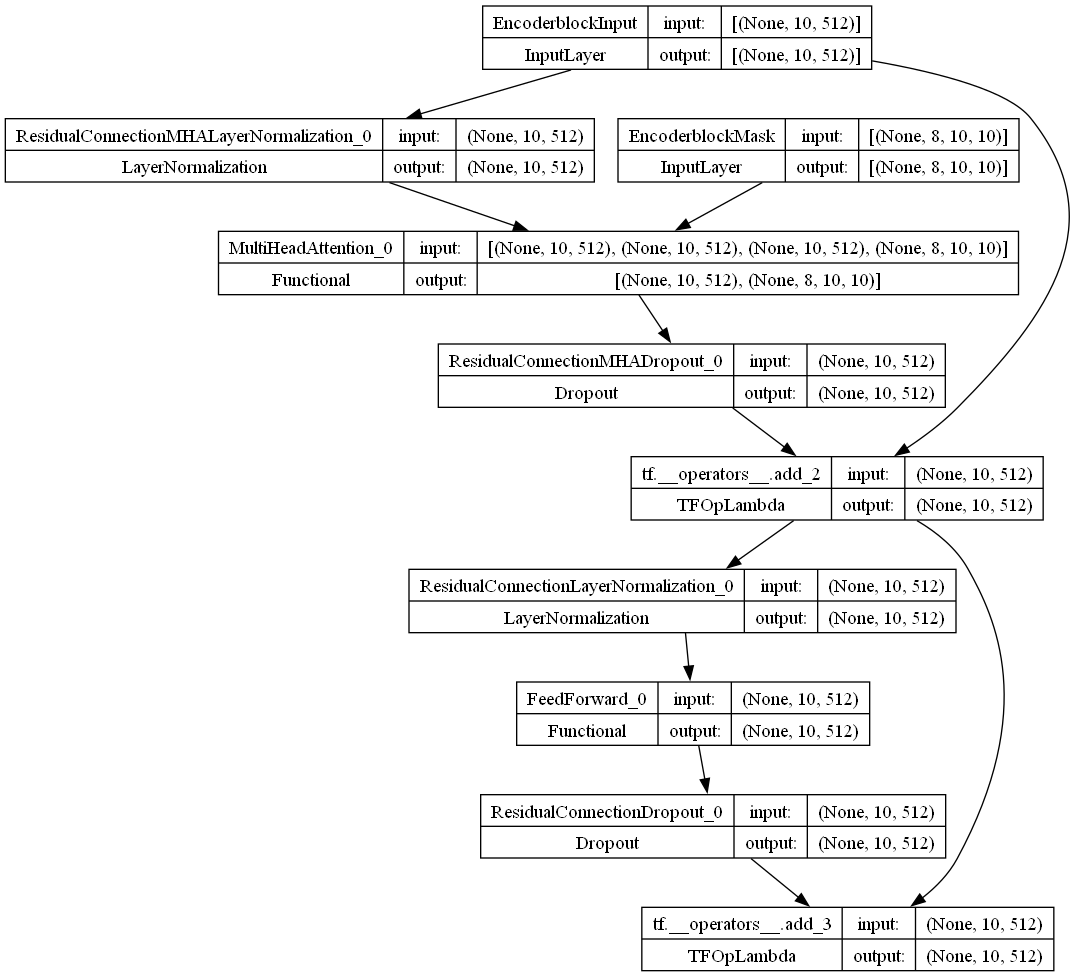

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [20]:
def Encoder(input_shape,mask_shape,n_blocks,d_model,n_heads,layer1_units_ff,layer2_units_ff,dropout_rate):

    # Pick up Encoder input and mask
    input = Input(shape=input_shape,name="Encoder_Input")
    mask = Input(shape=mask_shape,name="Encoder_Input_Mask")
    
    x = input
    # Attention outputs for visualization
    a_list = []
    # n_blocks Encoder Blocks
    for i in range(n_blocks):
        [x, a] = Encoderblock(
                    input_shape,
                    mask_shape,
                    MultiHeadAttention(
                        input_shape,
                        input_shape,
                        input_shape,
                        mask_shape,
                        d_model,
                        n_heads,
                        dropout_rate
                    ),
                    FeedForward(
                        input_shape,
                        layer1_units_ff,
                        layer2_units_ff,
                        dropout_rate
                    ),
                    dropout_rate,
                    i
                )([x,mask])

        a_list.append(a)

    # Layer Normalization to help during residual MHA in decoder
    x = LayerNormalization(name="Output_LayerNorm")(x)
    # Attention scores for visualization
    a_list = Concatenate(axis=1)(a_list)

    model = Model(inputs=[input,mask],outputs=[x,a_list],name="Encoder")

    return model

In [21]:
model=Encoder(
    intermediate_shape_encoder,
    mask_shape_encoder,
    n_blocks_encoder,
    d_model,
    n_heads,
    layer1_units_ff,
    layer2_units_ff,
    dropout_rate    
)
model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 10, 512)]    0           []                               
                                                                                                  
 Encoder_Input_Mask (InputLayer  [(None, 8, 10, 10)]  0          []                               
 )                                                                                                
                                                                                                  
 Encoderblock_0 (Functional)    [(None, 10, 512),    3152384     ['Encoder_Input[0][0]',          
                                 (None, 8, 10, 10)]               'Encoder_Input_Mask[0][0]']     
                                                                                            

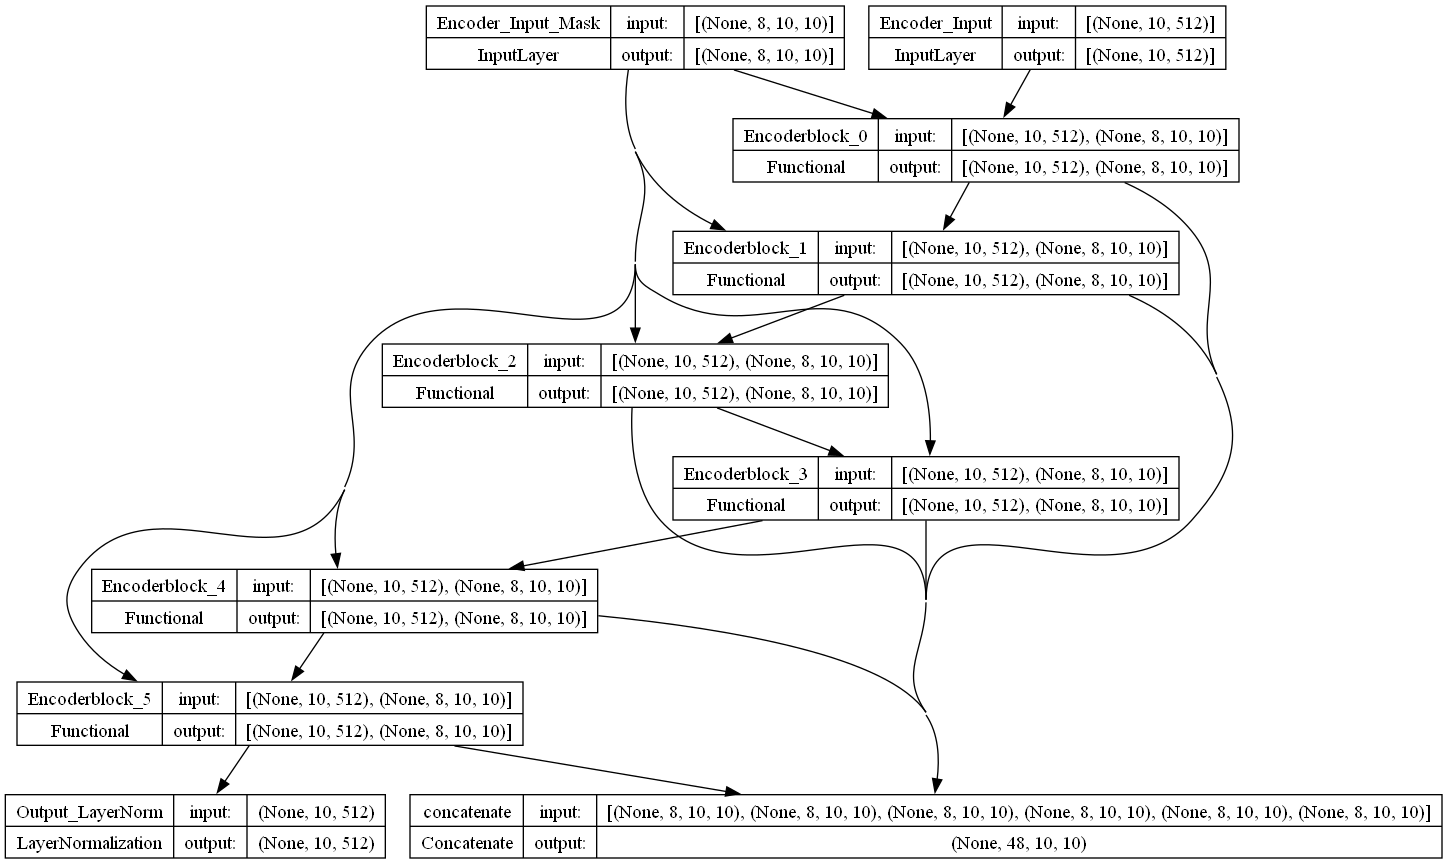

In [22]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [23]:
def Decoderblock(output_shape_encoder,input_shape_decoder,mask_shape_decoder,mask_shape_cross,Self_MHA_block,Cross_MHA_block,FeedForward_block,dropout_rate,index=0):
    
    # Pick up input and mask 
    encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask")
    decoder_mask = Input(shape=mask_shape_decoder,name="DecoderblockMask")
    input = Input(shape=input_shape_decoder,name="DecoderblockInput")
    encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput")

    # MHA Block with residual connection for self attention
    x, a_d = ResidualConnectionMHA(input,lambda x: Self_MHA_block([x, x, x, decoder_mask]),dropout_rate,0)
    # MHA Block with residual connection for cross attention
    x, a_c = ResidualConnectionMHA(x,lambda x: Cross_MHA_block([x, encoder_output, encoder_output, encoder_mask]),dropout_rate,1)
    # FF Block with residual connection
    x = ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,0)

    model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d,a_c],name=f"Decoderblock_{index}")

    return model

In [24]:
model=Decoderblock(
    intermediate_shape_encoder,
    intermediate_shape_decoder,
    mask_shape_decoder,
    mask_shape_cross,
    MultiHeadAttention(
        intermediate_shape_decoder,
        intermediate_shape_decoder,
        intermediate_shape_decoder,
        mask_shape_decoder,
        d_model,
        n_heads,
        dropout_rate,
        0
    ),
    MultiHeadAttention(
        intermediate_shape_decoder,
        intermediate_shape_encoder,
        intermediate_shape_encoder,
        mask_shape_cross,
        d_model,
        n_heads,
        dropout_rate,
        1
    ),
    FeedForward(
        intermediate_shape_decoder,
        layer1_units_ff,
        layer2_units_ff,
        dropout_rate
    ),
    dropout_rate
)
model.summary()

Model: "Decoderblock_0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DecoderblockInput (InputLayer)  [(None, 100, 512)]  0           []                               
                                                                                                  
 ResidualConnectionMHALayerNorm  (None, 100, 512)    1024        ['DecoderblockInput[0][0]']      
 alization_0 (LayerNormalizatio                                                                   
 n)                                                                                               
                                                                                                  
 DecoderblockMask (InputLayer)  [(None, 8, 100, 100  0           []                               
                                )]                                                   

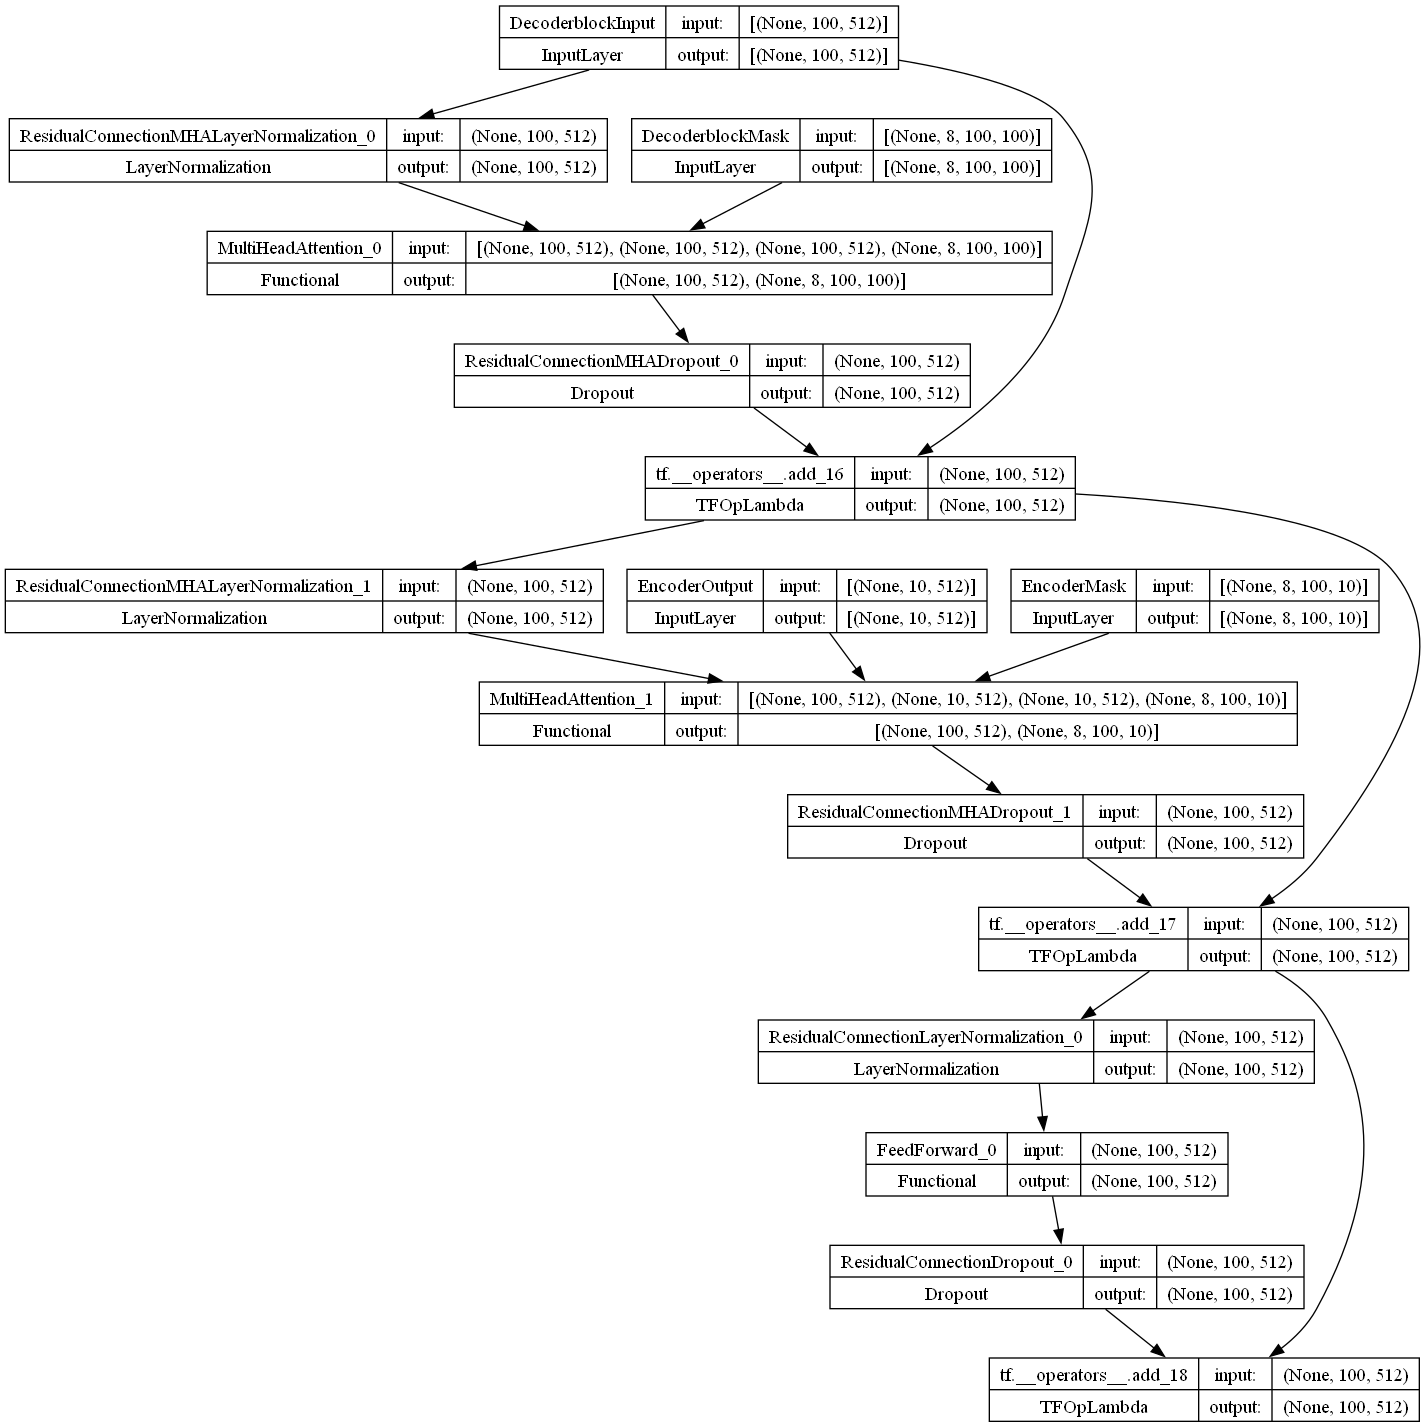

In [25]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [26]:
def Decoder(output_shape_encoder,input_shape_decoder,mask_shape_decoder,mask_shape_cross,n_blocks,d_model,n_heads,layer1_units_ff,layer2_units_ff,dropout_rate):

    # Pick up Decoder input, encoder_output, encoder_mask, decoder_mask
    encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask")
    decoder_mask = Input(shape=mask_shape_decoder,name="DecoderMask")
    input = Input(shape=input_shape_decoder,name="DecoderInput")
    encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput")
    
    x = input
    # Attention outputs for visualization
    a_d_list = []
    a_c_list = []
    # n_blocks Encoder Blocks
    for i in range(n_blocks):
        [x, a_d, a_c] = Decoderblock(
                            output_shape_encoder,
                            input_shape_decoder,
                            mask_shape_decoder,
                            mask_shape_cross,
                            MultiHeadAttention(
                                input_shape_decoder,
                                input_shape_decoder,
                                input_shape_decoder,
                                mask_shape_decoder,
                                d_model,
                                n_heads,
                                dropout_rate,
                                0
                            ),
                            MultiHeadAttention(
                                input_shape_decoder,
                                output_shape_encoder,
                                output_shape_encoder,
                                mask_shape_cross,
                                d_model,
                                n_heads,
                                dropout_rate,
                                1
                            ),
                            FeedForward(
                                input_shape_decoder,
                                layer1_units_ff,
                                layer2_units_ff,
                                dropout_rate
                            ),
                            dropout_rate,
                            i
                        )([x,encoder_output,encoder_mask,decoder_mask])

        a_d_list.append(a_d)
        a_c_list.append(a_c)

    # Layer Normalization to help during residual MHA in decoder
    x = LayerNormalization(name="Output_LayerNorm")(x)
    # Attention scores for visualization
    a_d_list = Concatenate(axis=1)(a_d_list)
    a_c_list = Concatenate(axis=1)(a_c_list)

    model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d_list,a_c_list],name="Decoder")

    return model

In [27]:
model=Decoder(
    intermediate_shape_encoder,
    intermediate_shape_decoder,
    mask_shape_decoder,
    mask_shape_cross,
    n_blocks_decoder,
    d_model,
    n_heads,
    layer1_units_ff,
    layer2_units_ff,
    dropout_rate
)
model.summary()

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DecoderInput (InputLayer)      [(None, 100, 512)]   0           []                               
                                                                                                  
 EncoderOutput (InputLayer)     [(None, 10, 512)]    0           []                               
                                                                                                  
 EncoderMask (InputLayer)       [(None, 8, 100, 10)  0           []                               
                                ]                                                                 
                                                                                                  
 DecoderMask (InputLayer)       [(None, 8, 100, 100  0           []                         

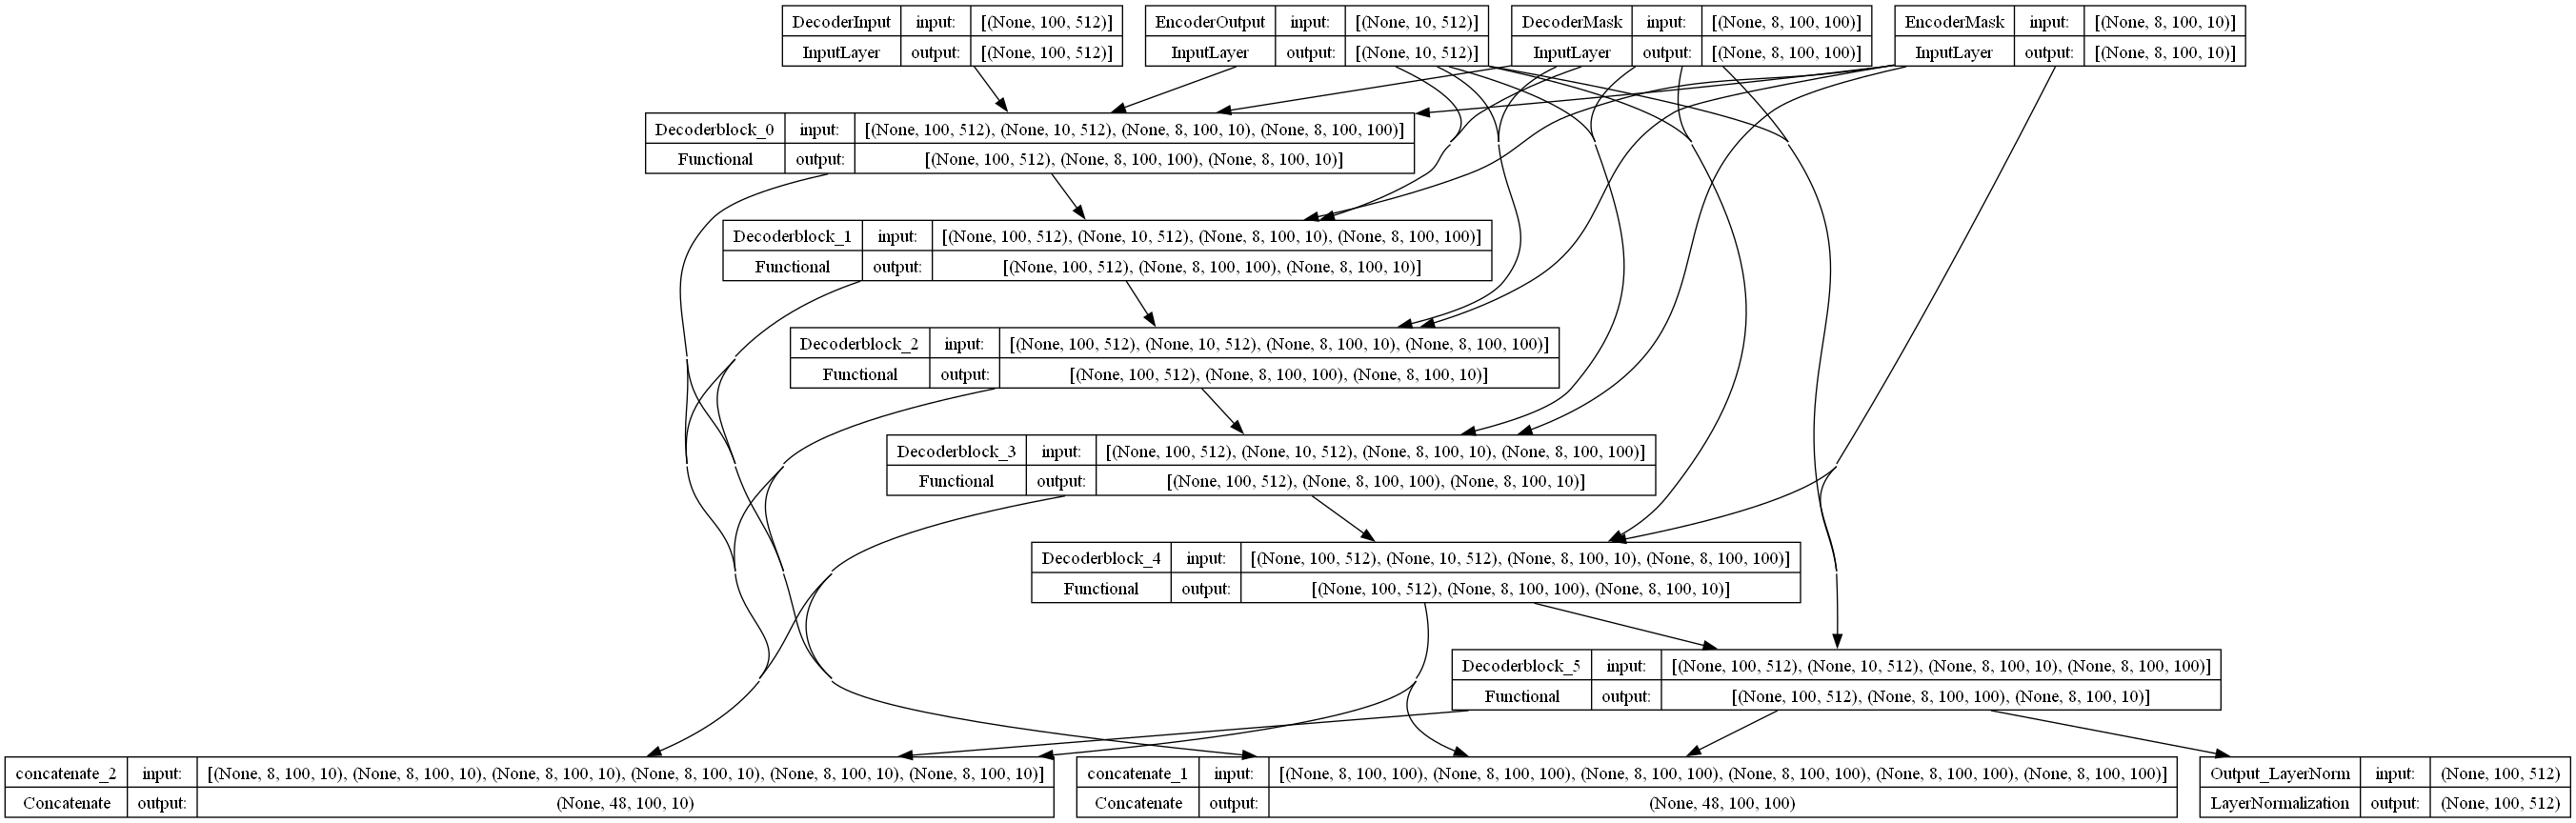

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [29]:
def ProjectionLayer(input_shape,d_model,vocab_size):

    # Pick Decoder outputs
    input = Input(shape=input_shape,name="Projection_Input")
    # Softmax for vocab_size
    x = Dense(vocab_size,activation='linear',name="Projection_Softmax")(input)

    model = Model(inputs=[input],outputs=[x],name="Softmax_Projection")

    return model

In [30]:
model=ProjectionLayer(
    intermediate_shape_decoder,
    d_model,
    trg_vocab_size
)
model.summary()

Model: "Softmax_Projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Projection_Input (InputLaye  [(None, 100, 512)]       0         
 r)                                                              
                                                                 
 Projection_Softmax (Dense)  (None, 100, 20000)        10260000  
                                                                 
Total params: 10,260,000
Trainable params: 10,260,000
Non-trainable params: 0
_________________________________________________________________


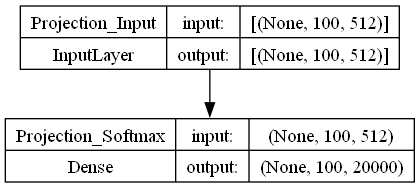

In [31]:
tf.keras.utils.plot_model(model,show_shapes=True)